In [1]:
import tensorflow as tf
from tensorflow import keras as k
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tf_data_augmentation import data_augment
import numpy as np

In [2]:
tf.keras.utils.set_random_seed(42) # sets the Python, NumPy and TensorFlow seed
# tf.config.experimental.enable_op_determinism() # forces threads to work in deterministic way

## Data load and splitting

In [3]:
(train_ds, val_ds), info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, as_supervised=True, split=['train+test[:70%]', 'test[70%:]'], download=True)

# Calculate the number of classes i.e.37
NUM_CLASSES = info.features['label'].num_classes
num_train = len(train_ds)
num_val = len(val_ds)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_val}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


## hyperparamaters

In [4]:
import os
BATCH_SIZE = 256
IMAGE_SIZE = 128
# Set environment variables
os.environ['NUM_CLASSES'] = str(NUM_CLASSES)
os.environ['BATCH_SIZE'] = str(BATCH_SIZE)
os.environ['IMAGE_SIZE'] = str(IMAGE_SIZE)

## visualization

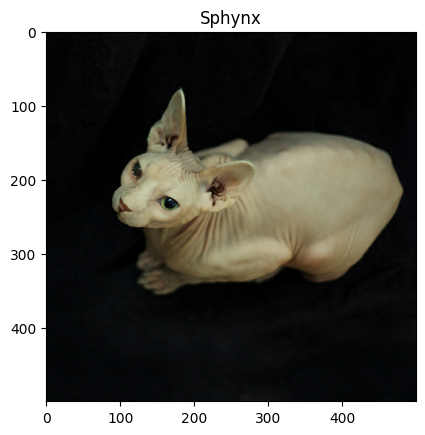

In [5]:
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title( get_label_name( label ) )

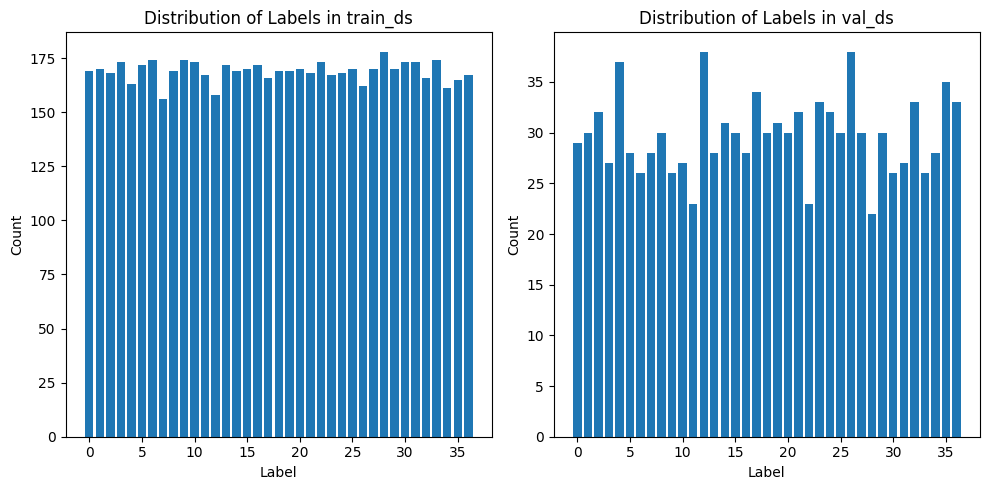

In [6]:
# Get the labels from train_ds and val_ds
train_labels = np.array([label.numpy() for _, label in train_ds])
val_labels = np.array([label.numpy() for _, label in val_ds])

# Count the occurrences of each label in train_ds and val_ds
train_label_counts = np.bincount(train_labels)
val_label_counts = np.bincount(val_labels)

# Plot the histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(train_label_counts)), train_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_ds')

plt.subplot(1, 2, 2)
plt.bar(range(len(val_label_counts)), val_label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in val_ds')

plt.tight_layout()
plt.show()

## Data Augmentation

In [7]:
train_ds, val_ds = data_augment(train_ds, val_ds)

In [8]:
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_val}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


## model

In [9]:
def alex_net(input_shape, classes: int = 37) -> k.Model:
    l2_reg = k.regularizers.l2(0.01)  # L2 regularization factor
    k.utils.set_random_seed(42)
    alexnet = k.Sequential([
        k.layers.Input(shape=input_shape),
        k.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu',
                        kernel_initializer="he_uniform", bias_initializer=k.initializers.Constant(value=0.1),
                        kernel_regularizer=l2_reg),
        k.layers.BatchNormalization(),
        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        k.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer="he_uniform", bias_initializer=k.initializers.Constant(value=0.1),
                        kernel_regularizer=l2_reg),
        k.layers.BatchNormalization(),
        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        k.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.HeUniform(), bias_initializer=k.initializers.Constant(value=0.1),
                        kernel_regularizer=l2_reg),

        k.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.HeUniform(), bias_initializer=k.initializers.Constant(value=0.1),
                        kernel_regularizer=l2_reg),

        k.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.HeUniform(), bias_initializer=k.initializers.Constant(value=0.1),
                        kernel_regularizer=l2_reg),

        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        k.layers.Flatten(),

        k.layers.Dense(units=4096, activation='relu', kernel_initializer="he_uniform", bias_initializer=k.initializers.Constant(value=0.1),
                       kernel_regularizer=l2_reg),
        k.layers.Dropout(0.5),

        k.layers.Dense(units=4096, activation='relu', kernel_initializer="he_uniform", bias_initializer=k.initializers.Constant(value=0.1),
                       kernel_regularizer=l2_reg),
        k.layers.Dropout(0.5),
    ])
    alexnet.add(k.layers.Dense(units=classes, activation='softmax', kernel_initializer="glorot_uniform",
                               bias_initializer=k.initializers.Constant(value=0.1), kernel_regularizer=l2_reg))
    return alexnet
alexnet_model = alex_net((IMAGE_SIZE, IMAGE_SIZE, 3), NUM_CLASSES)
alexnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 37)                  │         151,589 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,879,909 (94.91 MB)

 Trainable params: 24,879,205 (94.91 MB)

 Non-trainable params: 704 (2.75 KB)

In [10]:
alexnet_model.compile(
        optimizer=k.optimizers.Adam(learning_rate=0.00005),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = alexnet_model.fit(train_ds, epochs=6, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 154s 468ms/step - categorical_accuracy: 0.0366 - loss: 189.7074 - val_categorical_accuracy: 0.0427 - val_loss: 161.9684
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - categorical_accuracy: 0.0784 - loss: 153.4850 - val_categorical_accuracy: 0.1299 - val_loss: 129.6374
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - categorical_accuracy: 0.1229 - loss: 122.6084 - val_categorical_accuracy: 0.1653 - val_loss: 103.0011
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - categorical_accuracy: 0.1689 - loss: 97.3638 - val_categorical_accuracy: 0.2171 - val_loss: 81.6829
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - categorical_accuracy: 0.2050 - loss: 77.2849 - val_categorical_accuracy: 0.2670 - val_loss: 64.9572
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - categorical_accuracy: 0.2537 - loss: 61.5088 - val_categorical_accuracy: 0.2634 - val_loss: 52.0103


In [11]:
alexnet_model.compile(
        optimizer=k.optimizers.Adam(learning_rate=0.000001),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = alexnet_model.fit(train_ds, epochs=6, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - categorical_accuracy: 0.3087 - loss: 51.7773 - val_categorical_accuracy: 0.3143 - val_loss: 51.5427
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - categorical_accuracy: 0.3170 - loss: 51.3902 - val_categorical_accuracy: 0.3161 - val_loss: 51.1826
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - categorical_accuracy: 0.3163 - loss: 51.0315 - val_categorical_accuracy: 0.3106 - val_loss: 50.8316
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - categorical_accuracy: 0.3219 - loss: 50.6758 - val_categorical_accuracy: 0.3170 - val_loss: 50.4859
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - categorical_accuracy: 0.3193 - loss: 50.3318 - val_categorical_accuracy: 0.3170 - val_loss: 50.1480
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - categorical_accuracy: 0.3280 - loss: 49.9747 - val_categorical_accuracy: 0.3161 - val_loss: 49.8111


In [12]:
hist = alexnet_model.fit(train_ds, epochs=6, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - categorical_accuracy: 0.3280 - loss: 49.6436 - val_categorical_accuracy: 0.3179 - val_loss: 49.4786
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - categorical_accuracy: 0.3296 - loss: 49.3053 - val_categorical_accuracy: 0.3188 - val_loss: 49.1496
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - categorical_accuracy: 0.3356 - loss: 48.9800 - val_categorical_accuracy: 0.3161 - val_loss: 48.8278
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - categorical_accuracy: 0.3321 - loss: 48.6563 - val_categorical_accuracy: 0.3188 - val_loss: 48.5089
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - categorical_accuracy: 0.3379 - loss: 48.3209 - val_categorical_accuracy: 0.3197 - val_loss: 48.1904
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - categorical_accuracy: 0.3408 - loss: 47.9976 - val_categorical_accuracy: 0.3243 - val_loss: 47.8763


In [13]:
alexnet_model.compile(
        optimizer=k.optimizers.Adam(learning_rate=0.0000005),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )
hist = alexnet_model.fit(train_ds, epochs=6, shuffle=False, validation_data=val_ds, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=5)])

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - categorical_accuracy: 0.3413 - loss: 47.7300 - val_categorical_accuracy: 0.3188 - val_loss: 47.7218
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - categorical_accuracy: 0.3427 - loss: 47.5793 - val_categorical_accuracy: 0.3206 - val_loss: 47.5674
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - categorical_accuracy: 0.3425 - loss: 47.4207 - val_categorical_accuracy: 0.3243 - val_loss: 47.4119
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - categorical_accuracy: 0.3463 - loss: 47.2631 - val_categorical_accuracy: 0.3206 - val_loss: 47.2603
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - categorical_accuracy: 0.3410 - loss: 47.1101 - val_categorical_accuracy: 0.3252 - val_loss: 47.1074
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - categorical_accuracy: 0.3419 - loss: 46.9563 - val_categorical_accuracy: 0.3233 - val_loss: 46.9556
